In [1]:
from crpropa import *
import pylab as pl
import numpy as np 
%matplotlib inline

In [2]:
def dn_dE(E, gamma=2, R_cut=1e19, Z=1, f_A=1, J0=1):
    x = f_A * J0 * (E/1e18)**-gamma
    x *= fcut(E, Z, R_cut)
    return x

def fcut(E, Z, R_cut):
    if isinstance(E, float):
        if E < Z * R_cut:
            return 1
        else:
            return np.exp(1.0 - E/Z/R_cut)
    else:
        x = np.ones_like(E)
        select = (E > Z * R_cut)
        x[select] *= np.exp(1.0 - E[select]/Z/R_cut)
        return x
    
    
def make_plot_input(Zs, names, fracs, gamma, rcut, weights):
    E = np.logspace(18,21,num=1000)
    mysum = 0.0
    norm = E ** 3
    norm = 1.0
    for i in range(len(Zs)):
        flux = dn_dE(E, gamma=gamma, R_cut=rcut, Z=Zs[i], f_A=fracs[i], J0=1) * weights[i]
        J = norm * flux 
        pl.plot(E, J / J[0], label=names[i])
        mysum += flux
    
    J = norm * mysum
    pl.plot(E, J / J[0], c="k", linewidth=3) 
    pl.loglog()
    pl.legend(loc=4)
    pl.ylim(1e-5,1)
    pl.xlim(1e18,10.0**(20.5))


def plot_auger_data():
    logE, n, dn1, dn2 = np.loadtxt("auger.dat", unpack=True)

    Elinear = 10.0**logE
    y = Elinear**2 * n
    yerr1 = Elinear**2*dn1 / y[0]
    yerr2 = Elinear**2*dn2 / y[0]
#     y = n / Elinear
#     yerr1 = dn1 / Elinear / y[4]
#     yerr2 = dn2 / Elinear / y[4]
#     pl.errorbar(logE, y/y[4], yerr=(yerr1, yerr2), fmt="o", label="PAO data")
#     pl.semilogy()



# simulation setup
def setup_sim(fname):
    sim = ModuleList()
    sim.add( SimplePropagation(1*kpc, 10*Mpc) )
    sim.add( Redshift() )
    sim.add( PhotoPionProduction(CMB) )
    sim.add( PhotoPionProduction(IRB) )
    sim.add( PhotoDisintegration(CMB) )
    sim.add( PhotoDisintegration(IRB) )
    sim.add( NuclearDecay() )
    sim.add( ElectronPairProduction(CMB) )
    sim.add( ElectronPairProduction(IRB) )
    sim.add( MinimumEnergy( 1 * EeV) )
    
    # observer and output
    obs = Observer()
    obs.add( ObserverPoint() )
    output = TextOutput(fname, Output.Event1D)
    obs.onDetection( output )
    sim.add( obs )
#     # source
#     source = Source()
#     source.add( SourceUniform1D(1 * Mpc, 1000 * Mpc) )
#     source.add( SourceRedshift1D() )
    
#     print source.add.__doc__
    
    return sim, output

def add_composition_run(sim, source, Zs, mass, names, fracs, gamma, rcut, weights):
    composition = SourceComposition(1 * EeV, 100 * EeV, -gamma)
    
    for i in range(len(Zs)):
        composition.add(mass[i], Zs[i],  fracs[i])  # H
    source.add( composition )
    
    # run simulation
    sim.setShowProgress(True)
    sim.run(source, 5000, True)
    
def make_plot_observed(fname):

    d = pl.genfromtxt(fname, names=True, invalid_raise=False)

    # observed quantities
    Z = pl.array([chargeNumber(id) for id in d['ID'].astype(int)])  # element
    A = pl.array([massNumber(id) for id in d['ID'].astype(int)])  # atomic mass number
    lE = pl.log10(d['E']) + 18  # energy in log10(E/eV))

    lEbins = pl.arange(18, 20.51, 0.1)  # logarithmic bins
    lEcens = (lEbins[1:] + lEbins[:-1]) / 2  # logarithmic bin centers
    dE = 10**lEbins[1:] - 10**lEbins[:-1]  # bin widths

    # identify mass groups
    idx1 = Z == 1
    idx2 = (Z == 2) 
    idx3 = (Z > 2) * (Z <= 25)
    idx4 = (Z > 25)

    # calculate spectrum: J(E) = dN/dE 
    EE = (10.0 ** lEcens) ** 3
    EE = 1.0
    
    J  = EE * pl.histogram(lE, bins=lEbins)[0] / dE
    J1 = EE * pl.histogram(lE[idx1], bins=lEbins)[0] / dE
    J2 = EE * pl.histogram(lE[idx2], bins=lEbins)[0] / dE
    J3 = EE * pl.histogram(lE[idx3], bins=lEbins)[0] / dE
    J4 = EE * pl.histogram(lE[idx4], bins=lEbins)[0] / dE

    # normalize
    J1 /= J[0]
    J2 /= J[0]
    J3 /= J[0] 
    J4 /= J[0]
    J /= J[0]

    
    pl.plot(lEcens, J,  color='SaddleBrown')
    pl.plot(lEcens, J1, color='blue', label='Z = 1')
    pl.plot(lEcens, J2, color='grey', label='Z = 2')
    pl.plot(lEcens, J3, color='green', label='Z = 3-25')
    pl.plot(lEcens, J4, color='red', label='Z $>$ 25')
    
    plot_auger_data()
    
    
    #pl.legend(fontsize=20, frameon=True)
    pl.semilogy()
    #pl.ylim(1e-5)
    pl.grid()
    pl.ylabel('$J(E)$ [a.u.]')
    pl.xlabel('$\log_{10}$(E/eV)')
    #pl.savefig('sim1D_spectrum.png')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


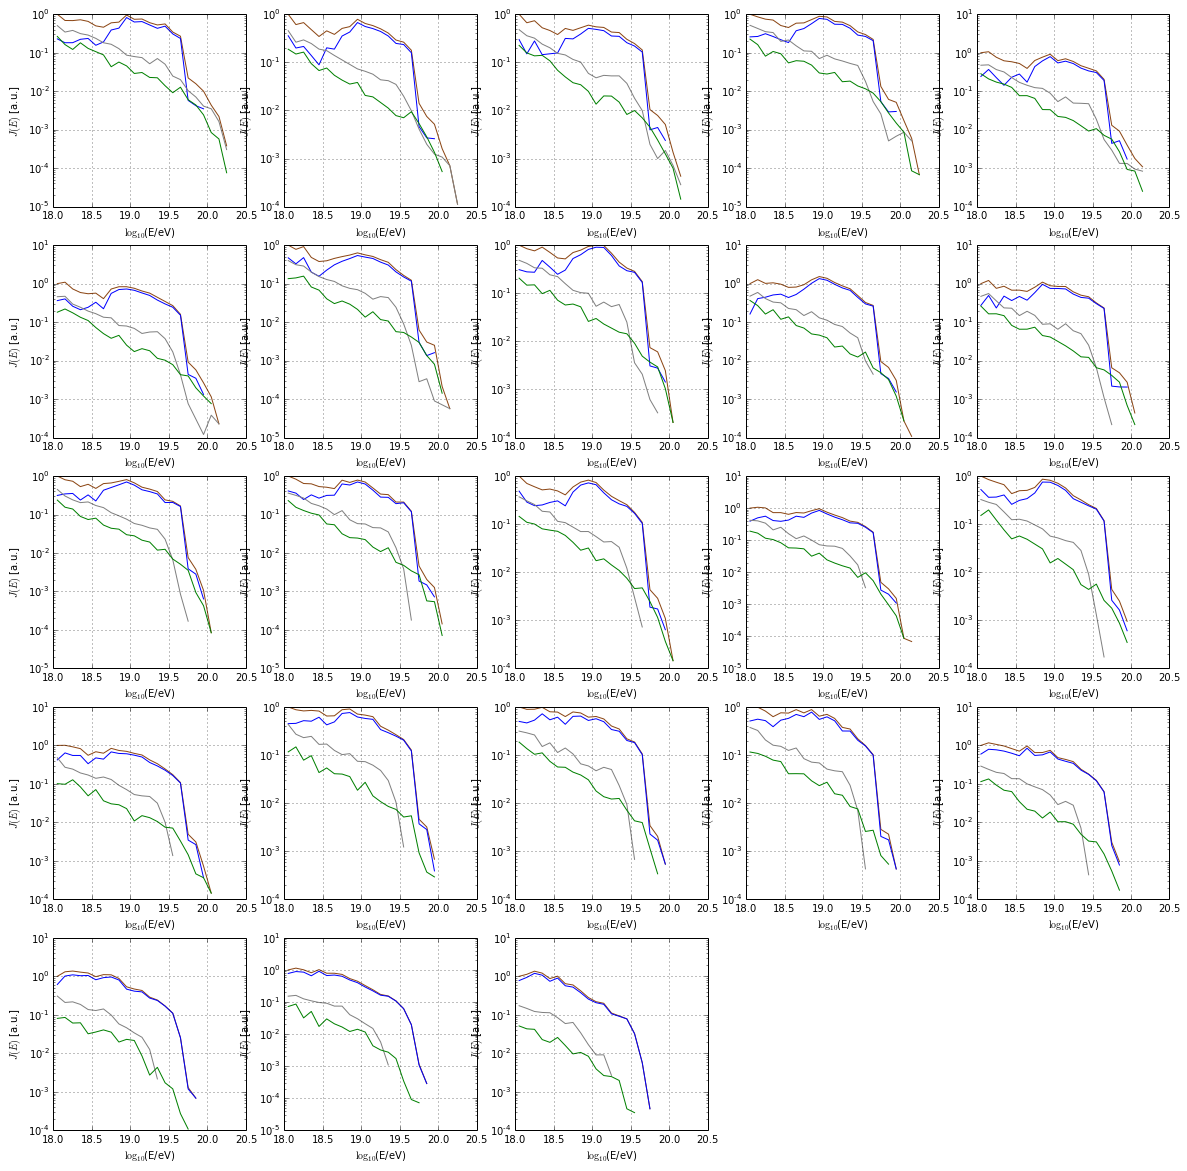

In [3]:
Zs = [1,2,7,14,26]
mass = [1,4,14,28,56]
names = ["H", "He", "N", "Si", "Fe"]
fracs = [0.125,0.586,0.246,0.042,0.0]
rcut = 10.0**18.66
gamma = 0.93
weights = [1.0, 0.328, 0.504, 0.168, 0.0]

distances, fluxes = np.genfromtxt("sbgs.dat", unpack=True, usecols = (3,5))

pl.figure(figsize=(20,20))
for i in range(len(distances)):
    
    print (i)
    
    fname = "modelsbg{}.txt".format(i)
    
    sim, output = setup_sim(fname)

    # source
    pl.subplot(5,5,i+1)
    source = Source()  
    source.add(SourcePosition(Vector3d(distances[i], 0, 0) * Mpc))
    source.add(SourceIsotropicEmission())
    #source.add(SourceParticleType(nucleusId(1, 1)))
    #source.add(SourcePowerLawSpectrum(1 * EeV, 200 * EeV, -1))
    #     source.add(SourceRedshiftEvolution(1.5, 0.001, 3))
    add_composition_run(sim, source, Zs, mass, names, fracs, gamma, rcut, weights)
    output.close()
    
    make_plot_observed(fname)

In [4]:
Zs = [1,2,7,14,26]
mass = [1,4,14,28,56]
names = ["H", "He", "N", "Si", "Fe"]
fracs = [0.125,0.586,0.246,0.042,0.0]
rcut = 10.0**18.66
gamma = 0.93
weights = [1.0, 0.328, 0.504, 0.168, 0.0]

distances_RG, fluxes_RG = np.genfromtxt("radio-gals.dat", unpack=True, usecols = (3,5))

pl.figure(figsize=(20,20))
for i in range(len(distances_RG)):
    
    print (i)
    
    fname = "modelRG{}.txt".format(i)
    
    sim, output = setup_sim(fname)

    # source
    source = Source()  
    source.add(SourcePosition(Vector3d(distances_RG[i], 0, 0) * Mpc))
    source.add(SourceIsotropicEmission())
    add_composition_run(sim, source, Zs, mass, names, fracs, gamma, rcut, weights)
    output.close()
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


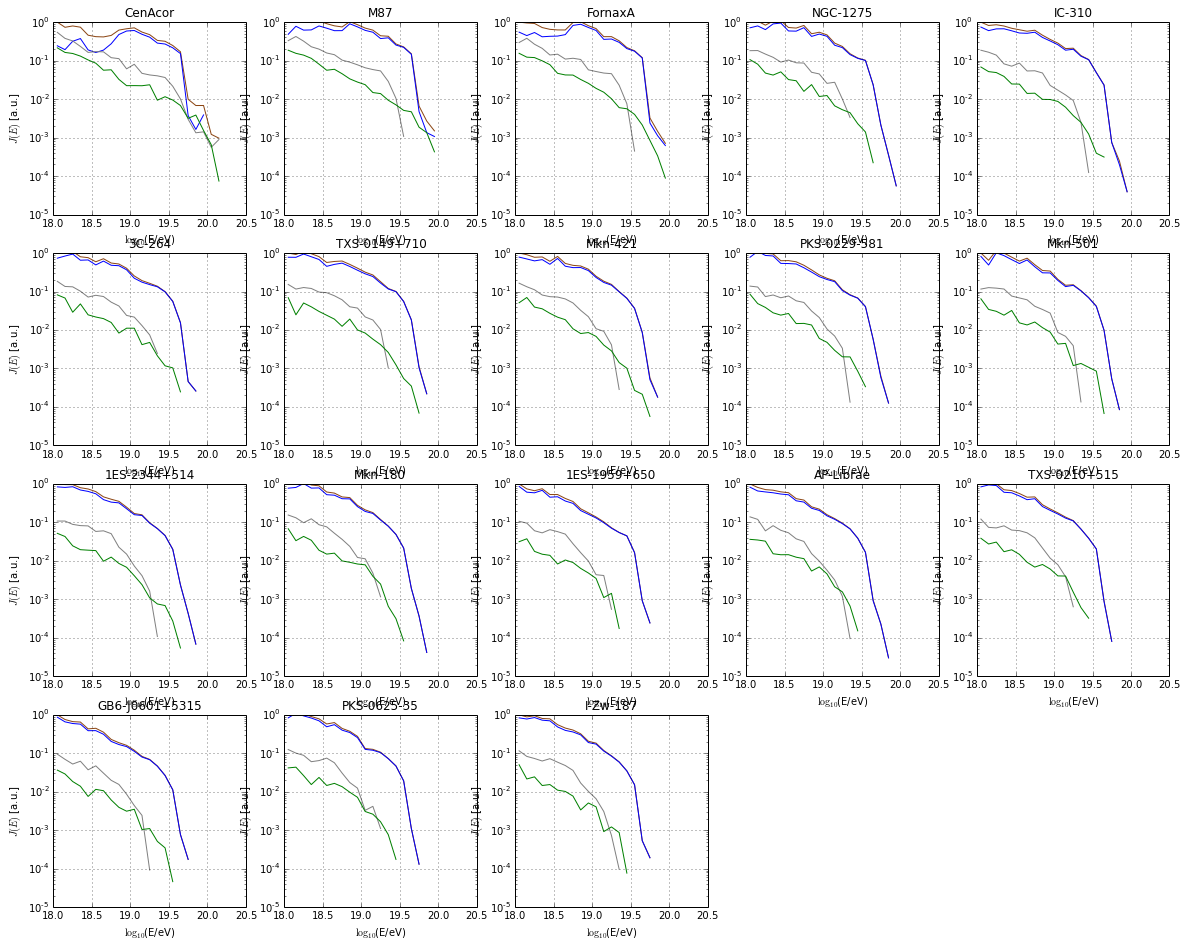

In [5]:
# plot the radio galaxies
pl.figure(figsize=(20,20))

names = np.genfromtxt("radio-gals.dat", unpack=True, usecols = (0), dtype=str)

for i in range(len(distances_RG)):
    pl.subplot(5,5,i+1)
    fname = "modelRG{}.txt".format(i)
    make_plot_observed(fname)
    pl.title(names[i])
    pl.ylim(1e-5,1)

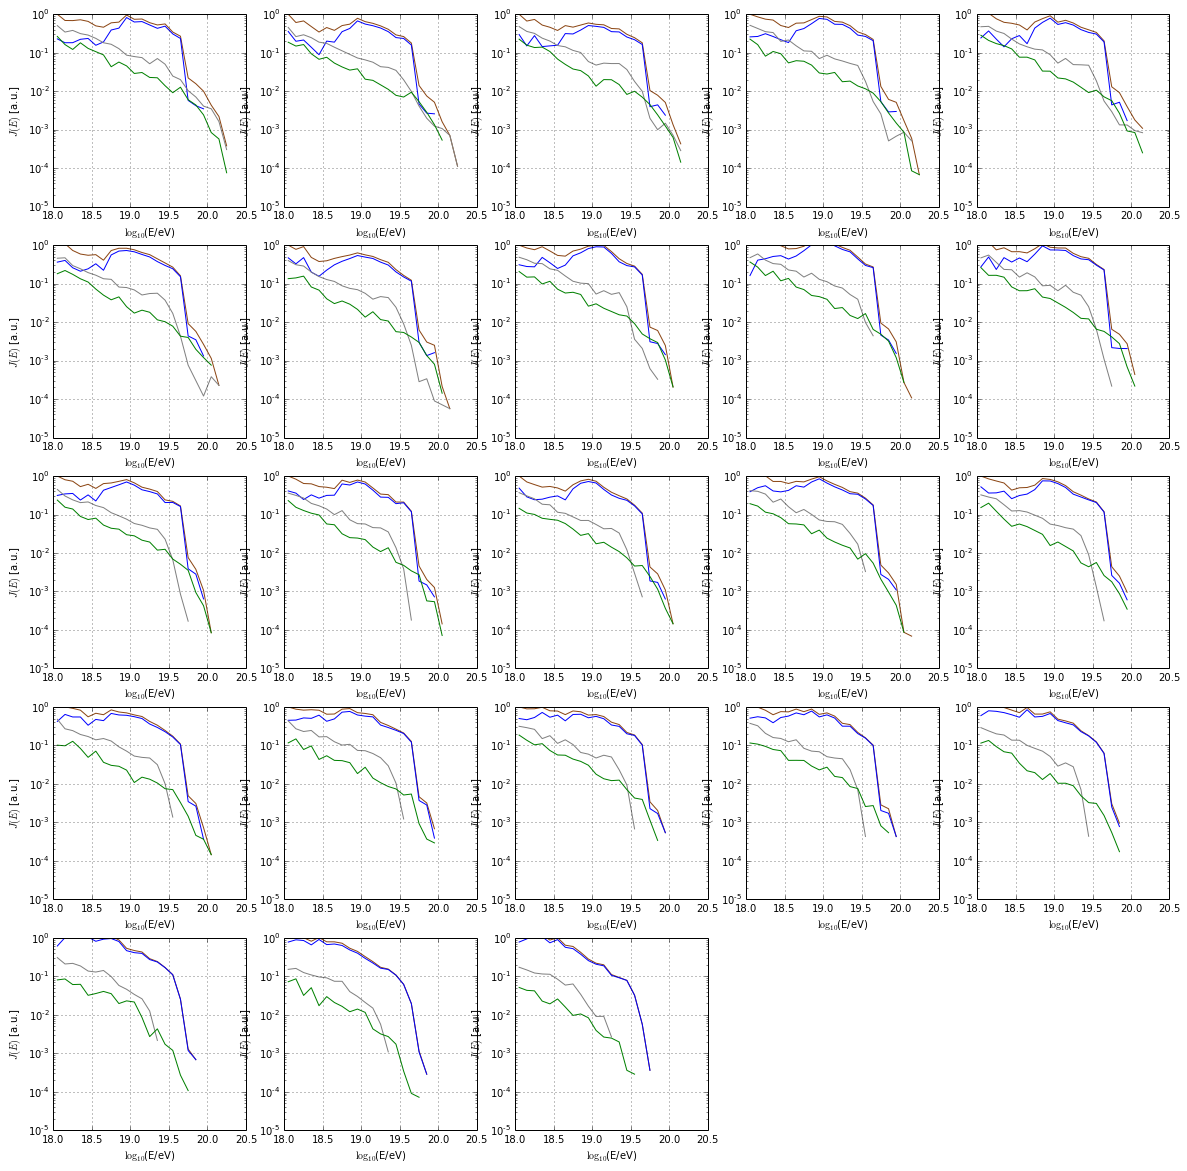

In [6]:
# now do starburst galaxies
pl.figure(figsize=(20,20))
for i in range(len(distances)):
    pl.subplot(5,5,i+1)
    fname = "modelsbg{}.txt".format(i)
    make_plot_observed(fname)
    pl.ylim(1e-5,1)